Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import sys
from random import shuffle

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sys.path.append('D:\Study\Applied Programming (Python)\Applied-Programming\Lab4')
from df_works import df_build, lemmatize_text

A function that adds a new column to dataset setting labels based on what rating is considered favourable 

In [2]:
def binarize(data: pd.DataFrame, rating: int) -> pd.DataFrame:
    data.dropna(inplace=True)
    change_labels = lambda x: 1 if x==rating else 0
    data['Label'] = data['Rating'].apply(change_labels)
    return data

Create dataframe and lemmatize the review texts inside

In [3]:
data = df_build('D:\Study\Applied Programming (Python)\Applied-Programming\Lab2\csv\dataset.csv')

remove_non_alphabets =lambda x: re.sub(r'[^a-zA-Z]',' ',x)
data = lemmatize_text(data)
data = binarize(data, 5)

In [11]:
max_words = 1000
cv = CountVectorizer(max_features=max_words, stop_words=stopwords.words('russian'))
sparse_matrix = cv.fit_transform(data['Review text']).toarray()
l = len(sparse_matrix)
print(sparse_matrix)
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(data['Label']))
x_train, x_val, y_train, y_val = train_test_split(sparse_matrix, np.array(data['Label']))
print(x_train.dtype)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
int64


Logistic regression

In [9]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(1000, 100)
        self.linear2 = nn.Linear(100, 20)
        self.linear3 = nn.Linear(20, 10)
        self.linear4 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [12]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
x_valid = Variable(torch.from_numpy(x_val)).float()
y_valid = Variable(torch.from_numpy(y_val)).long()

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)


In [13]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = 20
loss_values, models = [], []

Epoch 1/20, Training Loss: 0.6851, Training Accuracy: 0.5689, Validation Loss: 0.6863, Validation Accuracy: 0.5587
Epoch 2/20, Training Loss: 0.6825, Training Accuracy: 0.5689, Validation Loss: 0.6865, Validation Accuracy: 0.5587
Epoch 3/20, Training Loss: 0.6807, Training Accuracy: 0.5689, Validation Loss: 0.6856, Validation Accuracy: 0.5587
Epoch 4/20, Training Loss: 0.6770, Training Accuracy: 0.5689, Validation Loss: 0.6848, Validation Accuracy: 0.5587
Epoch 5/20, Training Loss: 0.6728, Training Accuracy: 0.5689, Validation Loss: 0.6837, Validation Accuracy: 0.5587
Epoch 6/20, Training Loss: 0.6664, Training Accuracy: 0.5689, Validation Loss: 0.6827, Validation Accuracy: 0.5587
Epoch 7/20, Training Loss: 0.6550, Training Accuracy: 0.5689, Validation Loss: 0.6805, Validation Accuracy: 0.5587
Epoch 8/20, Training Loss: 0.6409, Training Accuracy: 0.5689, Validation Loss: 0.6790, Validation Accuracy: 0.5587
Epoch 9/20, Training Loss: 0.6205, Training Accuracy: 0.5794, Validation Loss: 0

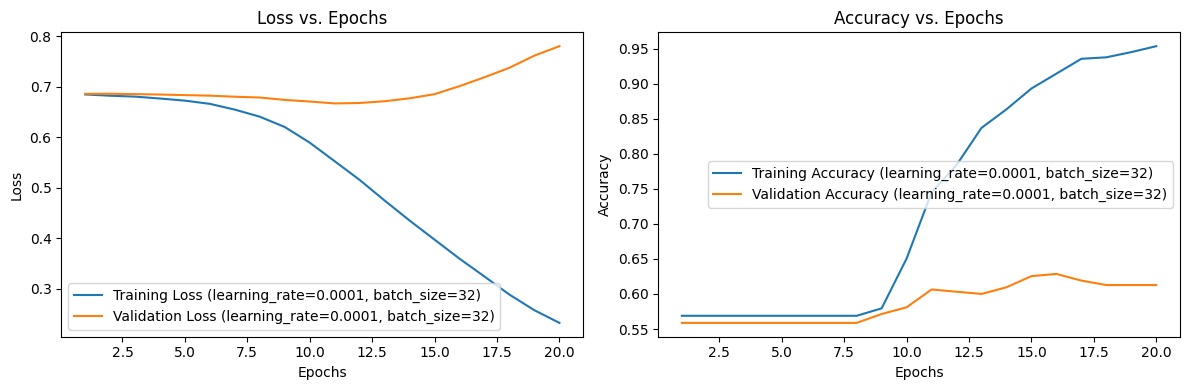

Epoch 1/20, Training Loss: 0.2112, Training Accuracy: 0.9566, Validation Loss: 0.8063, Validation Accuracy: 0.6063
Epoch 2/20, Training Loss: 0.1990, Training Accuracy: 0.9587, Validation Loss: 0.8185, Validation Accuracy: 0.5968
Epoch 3/20, Training Loss: 0.1880, Training Accuracy: 0.9619, Validation Loss: 0.8364, Validation Accuracy: 0.5937
Epoch 4/20, Training Loss: 0.1770, Training Accuracy: 0.9661, Validation Loss: 0.8500, Validation Accuracy: 0.5968
Epoch 5/20, Training Loss: 0.1667, Training Accuracy: 0.9693, Validation Loss: 0.8689, Validation Accuracy: 0.5937
Epoch 6/20, Training Loss: 0.1580, Training Accuracy: 0.9714, Validation Loss: 0.8870, Validation Accuracy: 0.5937
Epoch 7/20, Training Loss: 0.1480, Training Accuracy: 0.9725, Validation Loss: 0.9059, Validation Accuracy: 0.5968
Epoch 8/20, Training Loss: 0.1401, Training Accuracy: 0.9735, Validation Loss: 0.9252, Validation Accuracy: 0.6032
Epoch 9/20, Training Loss: 0.1319, Training Accuracy: 0.9756, Validation Loss: 0

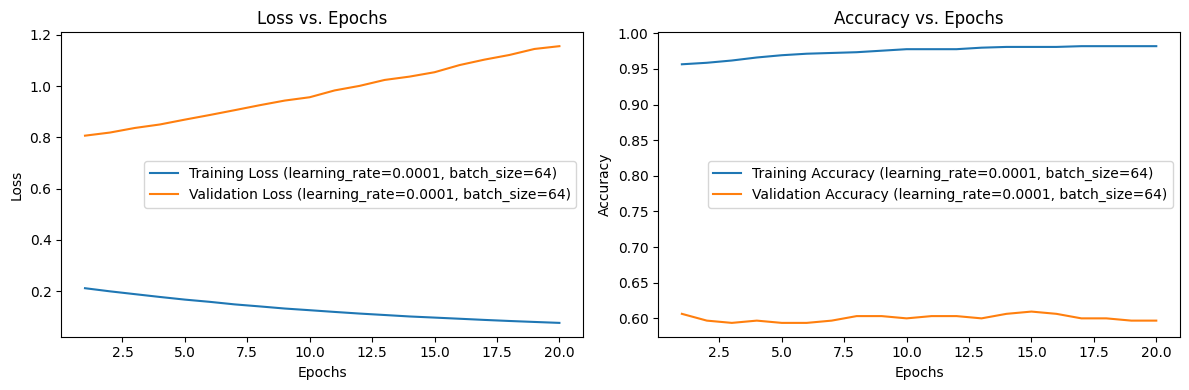

Epoch 1/20, Training Loss: 0.0764, Training Accuracy: 0.9831, Validation Loss: 1.1689, Validation Accuracy: 0.5968
Epoch 2/20, Training Loss: 0.0701, Training Accuracy: 0.9831, Validation Loss: 1.2372, Validation Accuracy: 0.6000
Epoch 3/20, Training Loss: 0.0655, Training Accuracy: 0.9831, Validation Loss: 1.2457, Validation Accuracy: 0.6000
Epoch 4/20, Training Loss: 0.0656, Training Accuracy: 0.9841, Validation Loss: 1.1538, Validation Accuracy: 0.5968
Epoch 5/20, Training Loss: 0.0656, Training Accuracy: 0.9841, Validation Loss: 1.2718, Validation Accuracy: 0.5968
Epoch 6/20, Training Loss: 0.0623, Training Accuracy: 0.9841, Validation Loss: 1.2435, Validation Accuracy: 0.5968
Epoch 7/20, Training Loss: 0.0591, Training Accuracy: 0.9841, Validation Loss: 1.2561, Validation Accuracy: 0.5905
Epoch 8/20, Training Loss: 0.0562, Training Accuracy: 0.9862, Validation Loss: 1.3013, Validation Accuracy: 0.5873
Epoch 9/20, Training Loss: 0.0582, Training Accuracy: 0.9862, Validation Loss: 1

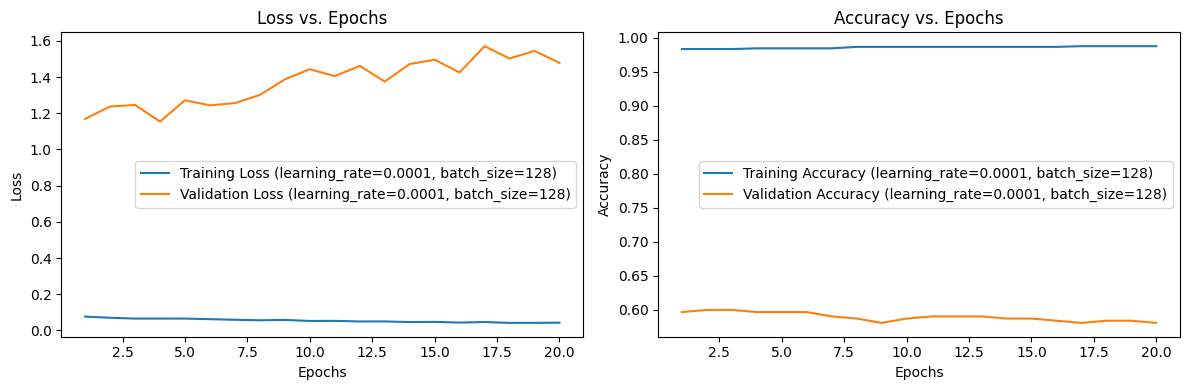

Epoch 1/20, Training Loss: 0.0456, Training Accuracy: 0.9883, Validation Loss: 1.9209, Validation Accuracy: 0.5905
Epoch 2/20, Training Loss: 0.0300, Training Accuracy: 0.9915, Validation Loss: 2.3039, Validation Accuracy: 0.5841
Epoch 3/20, Training Loss: 0.0236, Training Accuracy: 0.9915, Validation Loss: 2.6170, Validation Accuracy: 0.5873
Epoch 4/20, Training Loss: 0.0212, Training Accuracy: 0.9915, Validation Loss: 2.8198, Validation Accuracy: 0.6032
Epoch 5/20, Training Loss: 0.0181, Training Accuracy: 0.9926, Validation Loss: 3.1203, Validation Accuracy: 0.6000
Epoch 6/20, Training Loss: 0.0170, Training Accuracy: 0.9926, Validation Loss: 3.2732, Validation Accuracy: 0.5937
Epoch 7/20, Training Loss: 0.0165, Training Accuracy: 0.9873, Validation Loss: 3.4629, Validation Accuracy: 0.6032
Epoch 8/20, Training Loss: 0.0162, Training Accuracy: 0.9926, Validation Loss: 3.5717, Validation Accuracy: 0.5937
Epoch 9/20, Training Loss: 0.0150, Training Accuracy: 0.9926, Validation Loss: 3

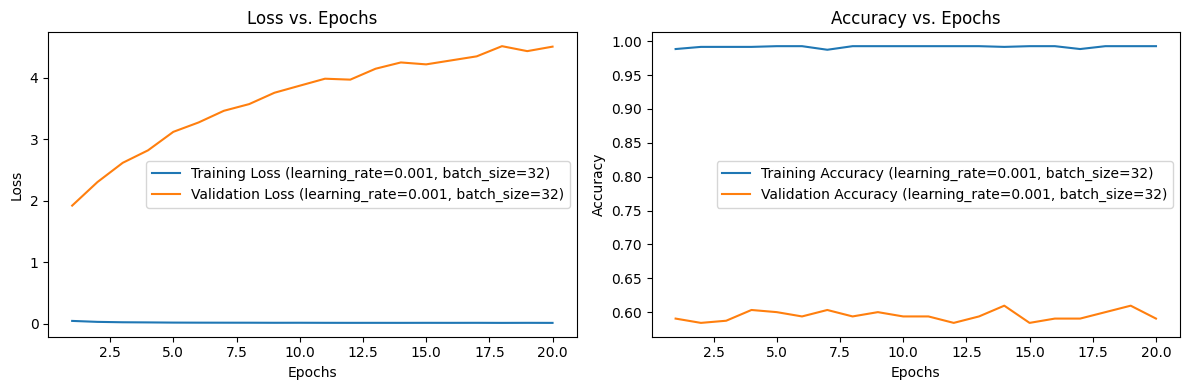

Epoch 1/20, Training Loss: 0.0138, Training Accuracy: 0.9926, Validation Loss: 4.6697, Validation Accuracy: 0.6095
Epoch 2/20, Training Loss: 0.0134, Training Accuracy: 0.9926, Validation Loss: 4.9429, Validation Accuracy: 0.6095
Epoch 3/20, Training Loss: 0.0136, Training Accuracy: 0.9926, Validation Loss: 4.9789, Validation Accuracy: 0.6159
Epoch 4/20, Training Loss: 0.0133, Training Accuracy: 0.9926, Validation Loss: 5.2246, Validation Accuracy: 0.6095
Epoch 5/20, Training Loss: 0.0134, Training Accuracy: 0.9926, Validation Loss: 5.2179, Validation Accuracy: 0.6063
Epoch 6/20, Training Loss: 0.0134, Training Accuracy: 0.9926, Validation Loss: 5.2757, Validation Accuracy: 0.6063
Epoch 7/20, Training Loss: 0.0130, Training Accuracy: 0.9926, Validation Loss: 5.4980, Validation Accuracy: 0.6095
Epoch 8/20, Training Loss: 0.0138, Training Accuracy: 0.9926, Validation Loss: 5.5616, Validation Accuracy: 0.6063
Epoch 9/20, Training Loss: 0.0159, Training Accuracy: 0.9841, Validation Loss: 5

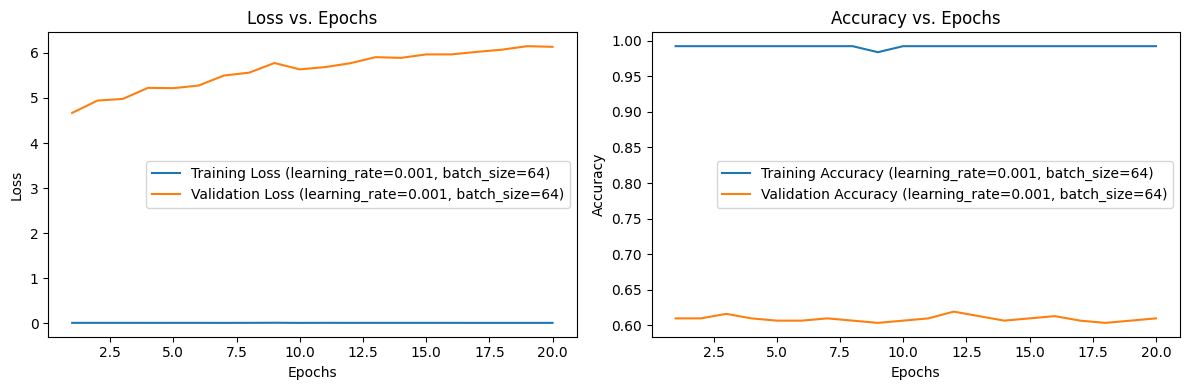

Epoch 1/20, Training Loss: 0.0126, Training Accuracy: 0.9905, Validation Loss: 6.0212, Validation Accuracy: 0.6032
Epoch 2/20, Training Loss: 0.0120, Training Accuracy: 0.9926, Validation Loss: 5.8496, Validation Accuracy: 0.6063
Epoch 3/20, Training Loss: 0.0126, Training Accuracy: 0.9926, Validation Loss: 6.2792, Validation Accuracy: 0.6063
Epoch 4/20, Training Loss: 0.0128, Training Accuracy: 0.9926, Validation Loss: 6.3778, Validation Accuracy: 0.6032
Epoch 5/20, Training Loss: 0.0134, Training Accuracy: 0.9926, Validation Loss: 6.3346, Validation Accuracy: 0.6063
Epoch 6/20, Training Loss: 0.0143, Training Accuracy: 0.9926, Validation Loss: 6.7469, Validation Accuracy: 0.6000
Epoch 7/20, Training Loss: 0.0135, Training Accuracy: 0.9926, Validation Loss: 6.6846, Validation Accuracy: 0.6032
Epoch 8/20, Training Loss: 0.0128, Training Accuracy: 0.9926, Validation Loss: 6.2718, Validation Accuracy: 0.6063
Epoch 9/20, Training Loss: 0.0129, Training Accuracy: 0.9926, Validation Loss: 7

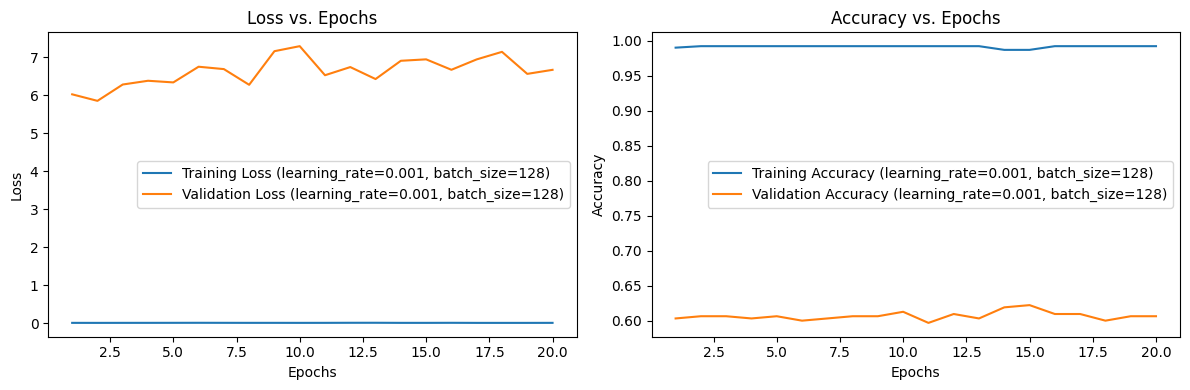

Epoch 1/20, Training Loss: 0.9193, Training Accuracy: 0.8602, Validation Loss: 2.5570, Validation Accuracy: 0.5524
Epoch 2/20, Training Loss: 0.1980, Training Accuracy: 0.9174, Validation Loss: 1.8395, Validation Accuracy: 0.5841
Epoch 3/20, Training Loss: 0.0456, Training Accuracy: 0.9841, Validation Loss: 2.2576, Validation Accuracy: 0.5619
Epoch 4/20, Training Loss: 0.0251, Training Accuracy: 0.9915, Validation Loss: 2.5183, Validation Accuracy: 0.5778
Epoch 5/20, Training Loss: 0.0302, Training Accuracy: 0.9915, Validation Loss: 2.7451, Validation Accuracy: 0.5270
Epoch 6/20, Training Loss: 0.0515, Training Accuracy: 0.9905, Validation Loss: 2.8902, Validation Accuracy: 0.5810
Epoch 7/20, Training Loss: 0.0177, Training Accuracy: 0.9915, Validation Loss: 2.7480, Validation Accuracy: 0.5365
Epoch 8/20, Training Loss: 0.0155, Training Accuracy: 0.9926, Validation Loss: 2.9028, Validation Accuracy: 0.5746
Epoch 9/20, Training Loss: 0.0147, Training Accuracy: 0.9926, Validation Loss: 3

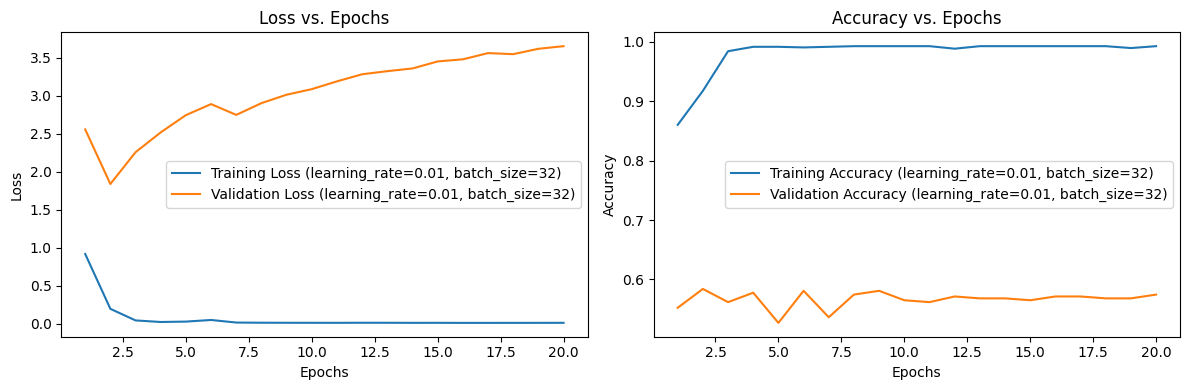

Epoch 1/20, Training Loss: 0.0288, Training Accuracy: 0.9852, Validation Loss: 5.4188, Validation Accuracy: 0.5556
Epoch 2/20, Training Loss: 0.0458, Training Accuracy: 0.9852, Validation Loss: 4.7171, Validation Accuracy: 0.5492
Epoch 3/20, Training Loss: 0.0264, Training Accuracy: 0.9831, Validation Loss: 4.4526, Validation Accuracy: 0.5937
Epoch 4/20, Training Loss: 0.0147, Training Accuracy: 0.9926, Validation Loss: 4.2764, Validation Accuracy: 0.5746
Epoch 5/20, Training Loss: 0.0151, Training Accuracy: 0.9905, Validation Loss: 5.0158, Validation Accuracy: 0.5683
Epoch 6/20, Training Loss: 0.0160, Training Accuracy: 0.9915, Validation Loss: 4.7371, Validation Accuracy: 0.5810
Epoch 7/20, Training Loss: 0.0182, Training Accuracy: 0.9915, Validation Loss: 5.0334, Validation Accuracy: 0.5683
Epoch 8/20, Training Loss: 0.0144, Training Accuracy: 0.9926, Validation Loss: 4.9878, Validation Accuracy: 0.5810
Epoch 9/20, Training Loss: 0.0162, Training Accuracy: 0.9905, Validation Loss: 5

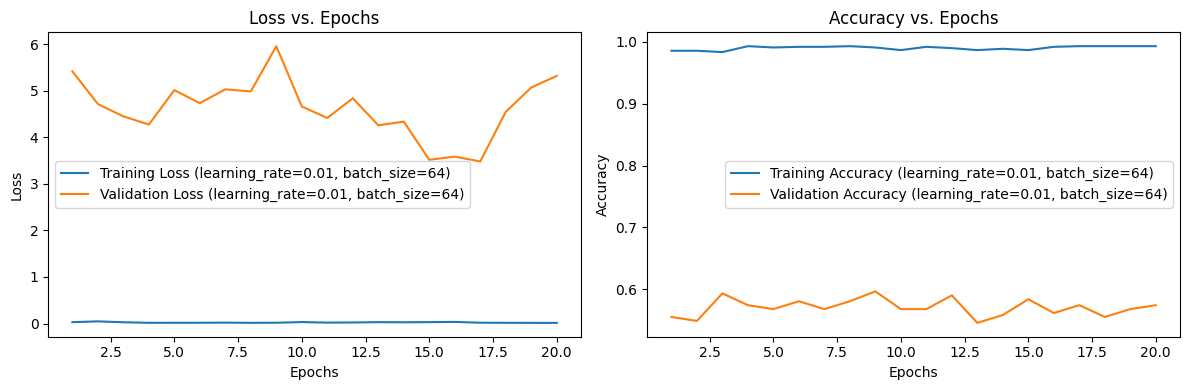

Epoch 1/20, Training Loss: 0.0151, Training Accuracy: 0.9894, Validation Loss: 9.2275, Validation Accuracy: 0.5746
Epoch 2/20, Training Loss: 0.0135, Training Accuracy: 0.9926, Validation Loss: 11.2700, Validation Accuracy: 0.5683
Epoch 3/20, Training Loss: 0.0172, Training Accuracy: 0.9926, Validation Loss: 12.2857, Validation Accuracy: 0.5524
Epoch 4/20, Training Loss: 0.0148, Training Accuracy: 0.9926, Validation Loss: 11.6316, Validation Accuracy: 0.5873
Epoch 5/20, Training Loss: 0.0118, Training Accuracy: 0.9926, Validation Loss: 10.1306, Validation Accuracy: 0.5683
Epoch 6/20, Training Loss: 0.0483, Training Accuracy: 0.9894, Validation Loss: 8.8963, Validation Accuracy: 0.5651
Epoch 7/20, Training Loss: 0.0358, Training Accuracy: 0.9905, Validation Loss: 8.2137, Validation Accuracy: 0.5651
Epoch 8/20, Training Loss: 0.0233, Training Accuracy: 0.9915, Validation Loss: 6.2366, Validation Accuracy: 0.5651
Epoch 9/20, Training Loss: 0.0148, Training Accuracy: 0.9915, Validation Los

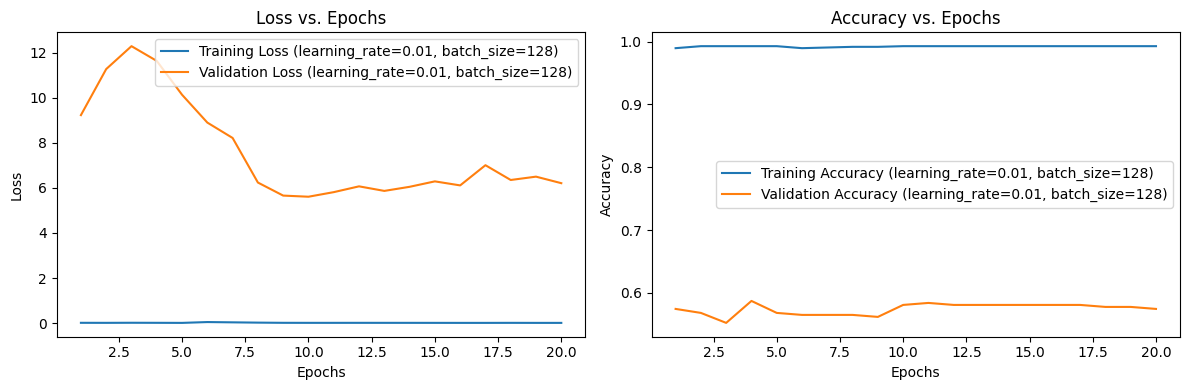

Test Accuracy: 0.8857


In [14]:
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        valid_losses = []
        train_accuracy = []
        valid_accuracy = []
        for epoch in range(epochs):
            model.train()

            cur_loss = 0.0
            correct_guesses = 0
            total_guesses = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                cur_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_guesses += labels.size(0)
                correct_guesses += (predicted == labels).sum().item()

            train_losses.append(cur_loss / len(train_loader))
            train_accuracy.append(correct_guesses / total_guesses)

            # Validation
            model.eval()

            cur_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    cur_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels).sum().item()

                valid_losses.append(cur_loss / len(valid_loader))
                valid_accuracy.append(correct_valid / total_valid)

                print(f'Epoch {epoch + 1}/{epochs}, '
                      f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
                      f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')
                models.append(model)

        # Visualization
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label=f'Training Loss (learning_rate={learning_rate}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_losses, label=f'Validation Loss (learning_rate={learning_rate}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracy, label=f'Training Accuracy (learning_rate={learning_rate}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_accuracy, label=f'Validation Accuracy (learning_rate={learning_rate}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. Epochs')

        plt.tight_layout()
        plt.show()

# Evaluate model on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')